In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
import seaborn as sns
sns.set_theme(color_codes=True)
from scipy import stats
import statsmodels.api as sm
import numpy as np
import json

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data cleaning

In [71]:
df = pd.read_csv("./Data/ede-questionnaire-third-round.csv")

In [72]:
questionnaire_raw_data = df
# questionnaire_raw_data = questionnaire_raw_data.dropna(axis=0, how='any')
questionnaire_respones = questionnaire_raw_data[questionnaire_raw_data.trial_type.isin(['table-completion', 'custom-form'])][['mturkID', 'experiment_id', 'trial_type', 'id', 'responses']]


In [73]:
len(questionnaire_respones.mturkID.unique())

126

In [74]:

def clean_table_questions(x):
    dic = {}
    a = json.loads(x)['responses']
    for i in a:
        dic[i] = a[i]['choices'][0]
    return dic

def clean_form_questions(x):
    dic = {}
    for i in json.loads(x):
        dic[i['id']] = i['value']
    return dic

def clean_questions(x,type):
    if(type == 'table-completion'):
        return clean_table_questions(x)
    elif(type == 'custom-form'):
        return clean_form_questions(x)
    else:
        return x

In [75]:
questionnaire_respones['clean_responses'] =  questionnaire_respones.apply(lambda x: clean_questions(x['responses'],x['trial_type']), axis=1)
questionnaire_respones.clean_responses = questionnaire_respones.clean_responses.apply(lambda x: list(x.items()))
a = questionnaire_respones.groupby('mturkID').agg({'clean_responses': 'sum'}).reset_index()
a['clean_responses_dict'] = a.clean_responses.apply(lambda x: dict(x))


In [76]:
df_dict = {}

for i in a.iterrows():
    df_dict[(i[1]['mturkID'])] = i[1]['clean_responses_dict']
questionnaire_clean_data = pd.DataFrame(df_dict).transpose().reset_index()
for i in range(0,48):
    questionnaire_clean_data[str(i+1)] =(questionnaire_clean_data[str(i+1)].astype(float))

In [80]:
questionnaire_clean_data['restraint'] = ((questionnaire_clean_data['1']) + questionnaire_clean_data['2'] + questionnaire_clean_data['3'] + (questionnaire_clean_data['4']) + (questionnaire_clean_data['5']))/5

questionnaire_clean_data['eating_concern'] = ((questionnaire_clean_data['7']) + questionnaire_clean_data['9'] + questionnaire_clean_data['20'] + (questionnaire_clean_data['19']) + (questionnaire_clean_data['21']))/5
questionnaire_clean_data['weight_concern'] = ((questionnaire_clean_data['22']) + questionnaire_clean_data['24'] + questionnaire_clean_data['8'] + (questionnaire_clean_data['25']) + (questionnaire_clean_data['12']))/5
questionnaire_clean_data['shape_concern'] = ((questionnaire_clean_data['6']) + questionnaire_clean_data['8'] + questionnaire_clean_data['23'] + (questionnaire_clean_data['10']) + (questionnaire_clean_data['26']) \
    + questionnaire_clean_data['27'] + questionnaire_clean_data['28'] + questionnaire_clean_data['11'])/8
questionnaire_clean_data['global_score'] = (questionnaire_clean_data['restraint'] + questionnaire_clean_data['eating_concern'] + questionnaire_clean_data['weight_concern'] + questionnaire_clean_data['shape_concern'])/4

questionnaire_clean_data['height_m'] = questionnaire_clean_data['heightfeet'].astype(float) * 0.3048 + questionnaire_clean_data['heightinch'].astype(float) * 0.0254 
questionnaire_clean_data['weight_kg'] = questionnaire_clean_data['weight'].astype(float)*0.453592
questionnaire_clean_data['BMI'] = questionnaire_clean_data['weight_kg']/questionnaire_clean_data['height_m']**2

questionnaire_clean_data['var_likert'] = questionnaire_clean_data[['1','2','3','4','5', '6', '7', '8','9','10','11','12','19','20','21','22','23','24','25','26','27','28']].std(axis=1)

a = (np.zeros(questionnaire_clean_data.shape[0]))

for i in range(29, 49):
    a += questionnaire_clean_data[str(i)]/20 

questionnaire_clean_data['desire_to_control'] = a


# Apply exclusion criteria

In [82]:
questionnaire_clean_data = questionnaire_clean_data[questionnaire_clean_data.var_likert != 0]

<AxesSubplot:xlabel='global_score', ylabel='BMI'>

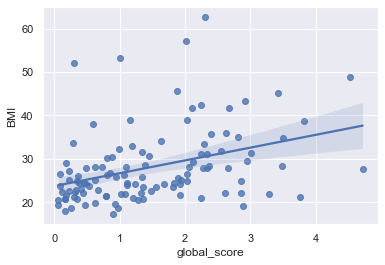

In [83]:
sns.regplot(x='global_score', y='BMI', data=questionnaire_clean_data)

<AxesSubplot:xlabel='restraint', ylabel='BMI'>

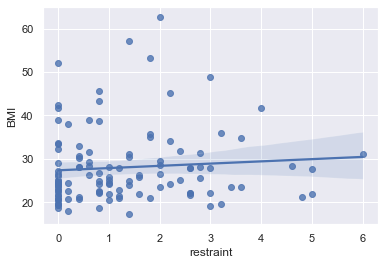

In [84]:
sns.regplot(x='restraint', y='BMI', data=questionnaire_clean_data)

<AxesSubplot:xlabel='eating_concern', ylabel='BMI'>

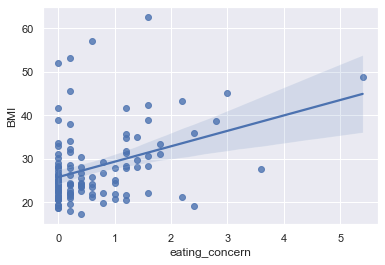

In [85]:
sns.regplot(x='eating_concern', y='BMI', data=questionnaire_clean_data)

<AxesSubplot:xlabel='shape_concern', ylabel='BMI'>

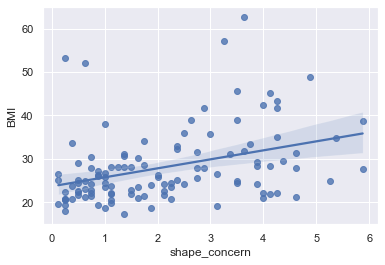

In [86]:
sns.regplot(x='shape_concern', y='BMI', data=questionnaire_clean_data)

<AxesSubplot:xlabel='weight_concern', ylabel='BMI'>

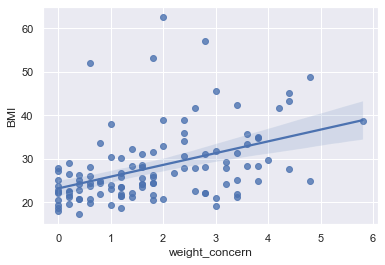

In [87]:
sns.regplot(x='weight_concern', y='BMI', data=questionnaire_clean_data)

<AxesSubplot:xlabel='desire_to_control', ylabel='global_score'>

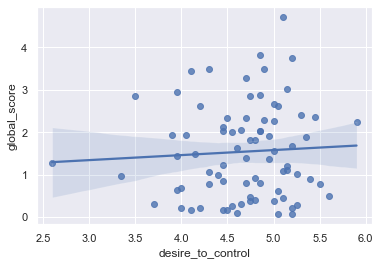

In [89]:
sns.regplot(x='desire_to_control', y='global_score', data=questionnaire_clean_data)

In [92]:
questionnaire_clean_data.to_csv('./Data/cleaned_questionnaire_data.csv')

In [93]:
questionnaire_clean_data

,index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,weight,heightfeet,heightinch,pet-0,pet-1,pet-type,pet-number,pet-timeperiod,restraint,eating_concern,weight_concern,shape_concern,global_score,height_m,weight_kg,BMI,var_likert,desire_to_control
0,A10BH9PYCYUKDJ,2.0,2.0,0.0,1.0,6.0,1.0,0.0,0.0,0.0,1.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,5.0,3.0,2.0,3.0,7.0,6.0,4.0,1.0,5.0,1.0,1.0,7.0,7.0,4.0,5.0,7.0,6.0,7.0,7.0,1.0,6.0,7.0,2.0,1.0,231,5,9,no,NaN,NaN,NaN,NaN,2.2,0.2,2.4,1.750,1.63750,1.7526,104.779752,34.112359,1.906925,4.60
1,A10JXOU89D5RXR,1.0,0.0,1.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,7.0,1.0,6.0,6.0,5.0,6.0,4.0,7.0,7.0,3.0,6.0,6.0,7.0,7.0,7.0,2.0,7.0,6.0,3.0,2.0,128,5,4,NaN,yes,cat and dog,2,12,1.6,0.2,0.8,1.500,1.02500,1.6256,58.059776,21.970906,1.698612,5.25
2,A10M63DSIGIEDI,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,4.0,13.0,17.0,4.0,5.0,12.0,8.0,1.0,0.0,4.0,3.0,2.0,3.0,2.0,1.0,4.0,3.0,3.0,4.0,3.0,3.0,2.0,4.0,6.0,5.0,5.0,4.0,2.0,4.0,4.0,6.0,5.0,4.0,3.0,3.0,5.0,4.0,202,5,8,NaN,yes,Dog,1,1,0.4,1.6,2.4,1.375,1.44375,1.7272,91.625584,30.713655,1.439246,3.95
3,A11S8IAAVDXCUS,3.0,3.0,4.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,6.0,6.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,6.0,0.0,5.0,5.0,3.0,6.0,6.0,6.0,6.0,6.0,1.0,2.0,1.0,1.0,5.0,4.0,5.0,5.0,7.0,1.0,6.0,6.0,5.0,1.0,5.0,5.0,3.0,6.0,4.0,178,5,5,NaN,yes,"cat, dog","2 dogs and so, so many cats","1 dog for 14 years, 1 for 10, and cats for 18",2.0,1.4,4.0,4.375,2.94375,1.6510,80.739376,29.620422,2.640018,3.95
4,A12FTSX85NQ8N9,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180,5,7,NaN,yes,Cat,2,16,1.0,0.4,1.6,1.375,1.09375,1.7018,81.646560,28.191673,1.220319,NaN
5,A12HZGOZQD5YK7,2.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,6.0,3.0,10.0,2.0,6.0,0.0,0.0,0.0,1.0,3.0,2.0,4.0,3.0,0.0,4.0,3.0,5.0,5.0,6.0,5.0,6.0,5.0,5.0,2.0,3.0,6.0,6.0,3.0,5.0,6.0,6.0,6.0,5.0,2.0,7.0,6.0,5.0,2.0,220,5,3,NaN,yes,Dog,2,16,0.6,1.6,2.4,3.500,2.02500,1.6002,99.790240,38.970819,1.777688,4.85
6,A12X8RUSITV7RU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,5.0,5.0,3.0,2.0,2.0,2.0,5.0,5.0,5.0,6.0,2.0,4.0,5.0,4.0,2.0,5.0,6.0,3.0,6.0,5.0,165,6,1,NaN,yes,Cat,8,23,0.0,0.0,0.2,0.500,0.17500,1.8542,74.842680,21.768885,0.611930,4.10
7,A136K4YZY2OFTV,4.0,5.0,4.0,6.0,4.0,6.0,1.0,1.0,3.0,4.0,5.0,6.0,4.0,4.0,4.0,0.0,0.0,2.0,0.0,3.0,1.0,4.0,4.0,2.0,5.0,5.0,4.0,4.0,6.0,5.0,5.0,6.0,6.0,6.0,2.0,7.0,7.0,2.0,6.0,3.0,6.0,7.0,6.0,2.0,7.0,6.0,1.0,2.0,186,5,8,NaN,yes,Dog,1,6,4.6,1.6,3.6,4.125,3.48125,1.7272,84.368112,28.280890,1.728924,4.90
8,A14LOABUGAITBM,2.0,0.0,2.0,3.0,0.0,5.0,1.0,1.0,0.0,0.0,1.0,1.0,6.0,6.0,4.0,0.0,0.0,22.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,7.0,5.0,4.0,3.0,5.0,7.0,7.0,7.0,7.0,5.0,7.0,6.0,7.0,7.0,3.0,2.0,7.0,3.0,7.0,2.0,120,5,10,NaN,yes,dog,1,10,1.4,0.4,0.4,1.375,0.89375,1.7780,54.431040,17.218016,1.214095,5.40
9,A14W0AXTJ3R19V,3.0,0.0,3.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,6.0,5.0,19.0,15.0,16.0,0.0,0.0,3.0,1.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,3.0,3.0,3.0,2.0,6.0,2.0,6.0,6.0,4.0,5.0,5.0,5.0,5.0,3.0,4.0,7.0,3.0,2.0,3.0,280,5,6,NaN,yes,dog,1,5,2.2,3.0,4.4,4.125,3.43125,1.6764,127.005760,45.192682,1.710674,4.10
